## 1. Create datasets and dataloders

###  1.1 Dataset Acquisition

The training dataset for ViT is large datasets, mainly ImageNet-21k or e JFT-300M dataset.
However, given this implementation is for beginners, the CIFAR-10 dataset, a small dataset, is used.

Step 1: Define the transforms that turn dataset into tensor representation.
- Training: To prevent overfitting, data augmentation configs are set
- Test : Just convert into tensors

Step 2: Download CIFAR10 datasets and load using `torchvision.datasets.CIFAR10` with defined transforms


In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import config


IMAGE_SIZE = config.IMAGE_SIZE
BATCH_SIZE = config.BATCH_SIZE
PATCH_SIZE = config.PATCH_SIZE
HEADS_NUM = config.HEADS_NUM
BLOCK_SIZE = config.BLOCK_SIZE
EMBED_DIM = config.EMBED_DIM
EPOCHS = config.EPOCHS

# Define the transformations for training and testing datasets

# Data augmentation for training
transform_train = T.Compose([
    T.RandomCrop(IMAGE_SIZE, padding=4),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

train_dataset = CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform_train)

test_dataset = CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform_test)

print(f"Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000, Test dataset size: 10000


### 1.2 Create dataloaders

With the loaded datasets, create train and test dataloaders with `torch.utils.data.DataLoader`

The paper has used mainly 4096 batch size but the here 128 is used due to limited GPU power. 

In [2]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=5,
    pin_memory=True)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=5,
    pin_memory=True)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 391
Number of test batches: 79


## 2. Build Model

The most essential part of this implementation is probably the architecture section.
Let's see how the transformer has been used in image data.

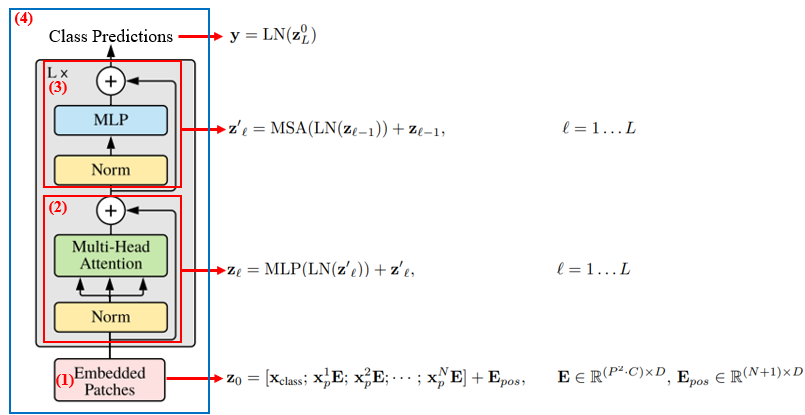

This section will build four classes:

1. ViTEmbedding : Corresponding to (1) in the image above 
2. MultiHEADAttention: (2)
3. TransformerEncoder: (2) + (3)
4. ViTTransformers: (4) = (1) + (2) + (3)

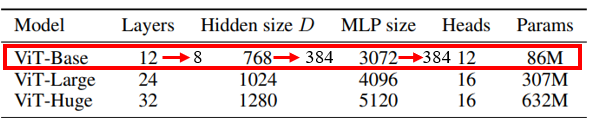

The ViT-Base model is selected for implementation. However, the number of **transformer blocks, embedding dimension (hidden size), and MLP size** are adjusted, as the CIFAR-10 dataset is used for training. Initially, the model was replicated exactly, but it led to severe overfitting. Therefore, the parameters were empirically modified to mitigate the issue

### 2.1 ViT Embeddings

1. Patch Embedding

- Input image shape: **(H, W, 3)**
- The image is split into non-overlapping patches of shape **(P, P, 3)**, where `P` is the patch size.
- Number of patches:
  \[
  N = H*W/P^2
  \]
- Each patch is **flattened** into a vector of shape **(P × P × 3)**.
- These vectors are passed through a **a Conv2D with `stride = P`, `kernel_size = P`** to get embeddings of shape **(N,D)** where D is embedding dimension.


2. [CLS] Token Addition

- A learnable **[CLS] token** of shape **(1, D)** is prepended to the patch embeddings.
- This token is used to summarize the global information for classification.
- **Output shape after adding [CLS] token**: **(N + 1, D)**

3. Positional Embedding

- To retain positional information, a **learnable positional embedding** of shape **(N + 1, D)** is added element-wise to the embeddings.
- **Final embedding shape before transformer encoder**: **(N + 1, D)**


In [3]:
import torch
import torch.nn as nn

# Embedding Layer for Vision Transformer
class ViTEmbedding(nn.Module):
    def __init__(self, img_size=IMAGE_SIZE, patch_size=PATCH_SIZE, in_channels=3, embed_dim=EMBED_DIM):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)                     # (B, D, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)            # (B, N, D)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)       # (B, N+1, D)
        x = x + self.pos_embed                      # Positional encoding
        return x



### 2.2 Multi-head self attention

1. The input embeddings of shape **(N + 1, D)** are fed into the attention block.  

2. Embeddings are linearly projected to **Q, K, V** using learnable weights.  
   - Shape: **(N + 1, D)** → **(N + 1, D)** (per Q/K/V)

3. For multi-head attention, Q, K, V are split into **h heads**.  
   - Per head shape: **(N + 1, D/h)**

4. Attention scores are computed:  
   
   softmax(QK^T/sqrt(D))*V
   

5. Outputs from all heads are concatenated and passed through a final linear layer.  
   - Final output shape: **(N + 1, D)**



In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=config.EMBED_DIM, num_heads=config.HEADS_NUM):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert (
            self.head_dim * num_heads == embed_dim
        ), "embed_dim must be divisible by num_heads"

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, return_attention=False): # takes in embeddings of shpape (B, N + 1, D)
        B, N, D = x.shape # (B, N+1, D)
        qkv = self.qkv_proj(x)                                     # (B, N+1, 3*D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)  # (B, N+1, 3, H, D/H)
        qkv = qkv.permute(2, 0, 3, 1, 4)                           # (3, B, H, N+1, D/H)
        q, k, v = qkv[0], qkv[1], qkv[2]                           # Split Q, K, V

        attn_scores = torch.einsum("bhnd,bhmd->bhnm", q / (self.head_dim ** 0.5), k) # (B, H, N+1, N+1)
        attn_weights = torch.softmax(attn_scores, dim=-1) # (B, H, N+1, N+1)
        attn_output = torch.einsum("bhnm,bhmd->bhnd", attn_weights, v) # (B, H, N+1, D/H)
        attn_output = attn_output.transpose(1, 2).reshape(B, N, D)  # (B, H, N+1, D/H) --> (B, N+1, H, D/H) --> (B, N+1, D)
        
        if return_attention:
            return self.out_proj(attn_output), attn_weights

        return self.out_proj(attn_output)




### 2.3 Transformer Encoder

The encoder consists of two main components repeated in sequence:  
**(1) Multi-Head Self-Attention (MSA)** and **(2) Multi-Layer Perceptron (MLP)**.

1. The input embeddings are first layer-normalized, then passed through MHSA.  
   - A skip connection adds the MSA output to the original input.

2. The result is again layer-normalized and passed through the MLP.  
   - Another skip connection adds the MLP output to the MSA result.

3. The final output is passed to the next encoder block (if any).


In [5]:
# Transformer Encoder Block
class TransformerEncoder(nn.Module):  
    def __init__(self, embed_dim=config.EMBED_DIM):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim) # Normalization layer for MSA    

        self.norm2 = nn.LayerNorm(embed_dim) # Normalization layer for MLP

        self.MSA = MultiHeadAttention(embed_dim=embed_dim)
        
        self.MLP = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.MSA(self.norm1(x))   # (B, N+1, D)
        x = x + self.MLP(self.norm2(x))   # (B, N+1, D)
        return x




### 2.4 ViT Blocks

This section integrates the previously defined components into the full Vision Transformer.

1. The input image is first converted into patch embeddings using the `ViTEmbedding` class.
2. The embeddings are then passed through the `TransformerEncoder`, which is repeated for the specified number of blocks.
3. After processing through the transformer blocks, the `[CLS]` token is extracted and passed through an MLP head to produce the final class prediction.


In [6]:
# Full ViT Model
class ViTTransformers(nn.Module):  
    def __init__(self, num_classes=10, 
                 block_num=config.BLOCK_SIZE, 
                 img_size=config.IMAGE_SIZE, 
                 patch_size=config.PATCH_SIZE, 
                 in_channels=3, 
                 embed_dim=config.EMBED_DIM):
        super().__init__()

        self.embedding = ViTEmbedding(img_size,
                                      patch_size,
                                      in_channels, 
                                      embed_dim)
        self.encoder_layers = nn.ModuleList([  
            TransformerEncoder(embed_dim) for _ in range(block_num)
        ])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (B, N+1, D)
        for encoder in self.encoder_layers:
            x = encoder(x)
        cls_token = x[:, 0]  # Extract CLS token
        return self.classifier(cls_token)  # (B, num_classes)


### 2.5 Inspection of the Created Architecture

Now that the Vision Transformer model has been successfully constructed, we can test it to verify the architecture.  

We'll pass a random input tensor through the model and display a summary to confirm that all layers and shapes are correctly defined.


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_0 = ViTTransformers().to(device)
test_input = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)  # Batch size of 32
output = model_0(test_input)
print(f"Output shape: {output.shape}")  # Should be (32, 10) for CIFAR-10

Output shape: torch.Size([128, 10])


In [8]:
from torchinfo import summary

summary(model=model_0, 
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViTTransformers (ViTTransformers)        [128, 3, 32, 32]     [128, 10]            --                   True
├─ViTEmbedding (embedding)               [128, 3, 32, 32]     [128, 65, 384]       25,344               True
│    └─Conv2d (patch_embed)              [128, 3, 32, 32]     [128, 384, 8, 8]     18,816               True
├─ModuleList (encoder_layers)            --                   --                   --                   True
│    └─TransformerEncoder (0)            [128, 65, 384]       [128, 65, 384]       --                   True
│    │    └─LayerNorm (norm1)            [128, 65, 384]       [128, 65, 384]       768                  True
│    │    └─MultiHeadAttention (MSA)     [128, 65, 384]       [128, 65, 384]       591,360              True
│    │    └─LayerNorm (norm2)            [128, 65, 384]       [128, 65, 384]       768                  True
│    │    └─Se

## 3. Training and testing

### 3.1 Setup for training

1. Loss Function: Cross-entropy loss is used, as it is suitable for multi-class classification problems.

2. Optimizer: Following the original paper, the Adam optimizer is used with a weight decay of 0.1. A base learning rate of 3×10⁻⁴ is adopted, based on both the paper's recommendation and empirical tuning.

3. Scheduler: Training is conducted for a total of 60 epochs, with the learning rate scaled by a factor of 0.1 every 20 epochs, determined through empirical experimentation.


In [9]:
#multistep
from torch.optim.lr_scheduler import MultiStepLR
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=3e-4, weight_decay=1e-1)

scheduler = MultiStepLR(optimizer, milestones=[20*i for i in range(1,3)], gamma=0.1)


### 3.2 Training

In [ ]:
from train import train

results =train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=config.EPOCHS,
      device=device,
      scheduler=scheduler
      )  # Reduced epochs for quicker testing

### 3.3 Result Visualization

After training the model, we visualize the following:

1. **Predictions with Corresponding Images**  
   - Display the input images alongside their predicted and ground-truth labels.  

2. **Attention Maps with Corresponding Images**  
   - Overlay the attention maps on top of the original images.  
   - This helps us understand where the model is focusing its attention.  
   - By interpreting the attention distribution, we can see **which parts of the image the model deems important** for making predictions.  
   - This supports model explainability and justifies its decisions.


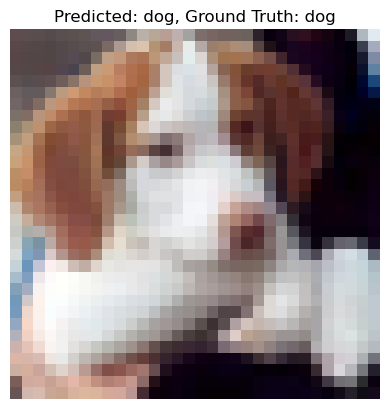

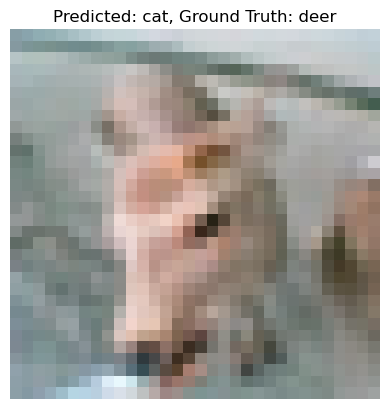

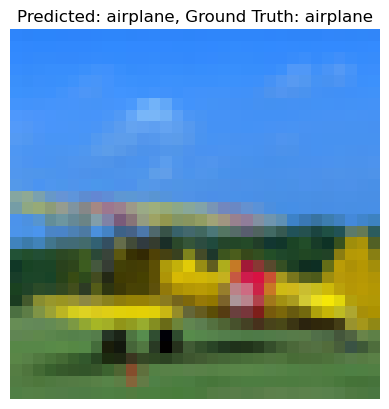

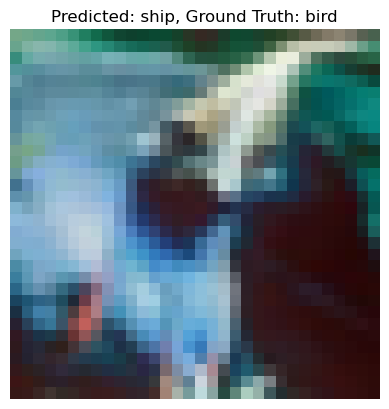

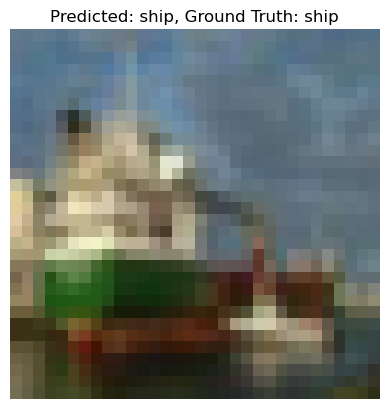

In [ ]:
# visualize the images with prediction and ground truth labels
import random
import matplotlib.pyplot as plt
import torch

# Function to denormalize the image
def denormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)  # Clamp before converting

# Get a batch of test images and labels
images, labels = next(iter(test_dataloader))
random_indices = random.sample(range(len(images)), 5)

model_0.eval()
with torch.inference_mode():
    for idx in random_indices:
        image = images[idx].unsqueeze(0).to(device)
        output = model_0(image)
        pred_idx = torch.argmax(output, dim=1)

        # Denormalize and move channel dimension last for display
        denorm_img = denormalize(images[idx].cpu()).permute(1, 2, 0).numpy()

        plt.imshow(denorm_img)
        plt.title(f"Predicted: {test_dataset.classes[pred_idx.item()]}, Ground Truth: {test_dataset.classes[labels[idx]]}")
        plt.axis('off')
        plt.show()


### 4. Save and load

In [ ]:
from pathlib import Path
from datetime import datetime

root_dir = Path('checkpoints')
if not root_dir.exists():
    root_dir.mkdir(parents=True, exist_ok=True)
# add timestamp to model save path
 
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = root_dir /f"vit_transformer_cifar10_{timestamp}.pth"
torch.save(model_0.state_dict(), model_save_path)

In [ ]:
# load the model

from pathlib import Path
device = "cuda" if torch.cuda.is_available() else "cpu"

root_dir = Path('checkpoints')
model_save_path = root_dir / "vit_transformer_cifar10_20250614_143351.pth"
model_0 = ViTTransformers(num_classes=10,
                          num_layers=BLOCK_SIZE,
                          img_size=IMAGE_SIZE,
                          patch_size=PATCH_SIZE,
                          in_channels=3,
                          embed_dim=EMBED_DIM).to(device)
model_0.load_state_dict(torch.load(model_save_path))

/tmp/ipykernel_678967/2861107806.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>